In [43]:
%matplotlib qt

# Preamble on MNE

For this assignment we'll be using MNE (https://mne.tools). MNE is the go-to library for working with EEG or MEG data in Python. 
It has many things already implemented for us, but it also has some quirks that make it a bit difficult. 
The main quirk that is relevant for us: MNE generally modifies data in-place, and returns the modified version. This means that when you call `cleaner_eeg = my_raw_eeg.drop_channels(['T7', 'T8'])` that these channels are now removed in both `cleaner_eeg` as well as in `my_raw_eeg`. 

Please have a look at the documentation provided by MNE here https://mne.tools/stable/api/python_reference.html whenever you get stuck, confused or curious. 

# Part 1

### Part 1: Questions 1 & 2

We offer some code to help you with this assignment. The first cell we include loads the EEG data and manages the metadata from the EEGBCI dataset.

It downloads the EEG recordings of subject 7, and selects the trials where this subject did left and right hand motor imagery/execution. 
All EEG data is concatenated resulting in one object with the raw EEG data called `raw`. 

For question 1. you need to inspect this raw data. 
For question 2. you'll need to apply a band-pass filter to this raw data.


In [44]:
import mne

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppresses an annoying warning
mne.set_log_level('warning')

from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage


subject = 7 # Here we pick an individual subject with good performance. In total there are 109 subjects.
runs = [3, 4, 7, 8, 11, 12] # We're actually selecting both Motor Imagery and Motor Execution trials here!
raw_fnames = eegbci.load_data(subject, runs)
raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
original_raw = concatenate_raws(raws)

eegbci.standardize(original_raw)  # set channel names
montage = make_standard_montage("standard_1005") # Defines position of electrodes on head
original_raw.set_montage(montage)

raw = original_raw.copy()

In [28]:
raw.plot() # This will visualise the EEG data. T0 = Rest, T1 = Left, T2 = Right
# Tip: Look under Help to see the controls

KeyboardInterrupt: 

In [45]:
# This cell extracts epochs containing the EEG data while the subject is performing the task.
# The epochs object can be inspected with epochs.plot()
# X and y are taken here to analyse the EEG data.


from mne import Epochs
from mne import events_from_annotations

event_id = dict(left=0, right=1)
events, _ = events_from_annotations(raw, event_id=dict(T1=0, T2=1))


epochs = Epochs(
    raw,
    events,
    event_id,
    tmin=0,
    tmax=4,
    baseline=None
)


X = epochs.get_data() # X is a numpy array of trials x channels x samples
y = epochs.events[:, -1]
print(y) # 0 = left, 1 = right

[1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1
 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1]


### Part 1: Questions 2+3

The cell below shows a first attempt at a Machine Learning model using CSP and LDA.
Before solving question 2. you may observe the model performance printed here.
After solving implementing the temporal filter you may see a change in performance here.

In question 3 here you may also modify the number of CSP filters, and inspect the learned filters. 

In [46]:
# This cell provides a first attempt at making a CSP-LDA classifier. First CSP is applied to the data, then the results of CSP are passed on to LDA.
# The data is split into a train and test section as cross-validation. 
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

csp = CSP(n_components=1)
lda = LDA()

csp.fit(X_train, y_train)

features = csp.transform(X_train)

lda.fit(features, y_train)

y_prediction = lda.predict(csp.transform(X_test))
print("AUROC:", roc_auc_score(y_test, y_prediction))

AUROC: 0.474025974025974


**Filter raw data between 13 and 30 Hz**

In [47]:
### Filter between 8 and 25 Hz ###
raw_filtered = raw.copy()
raw_filtered.filter(8, 25)

<RawEDF | S007R03.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>

In [48]:
### Create dataset ###
event_id = dict(left=0, right=1)
events, _ = events_from_annotations(raw_filtered, event_id=dict(T1=0, T2=1))

epochs = Epochs(
    raw_filtered,
    events,
    event_id,
    tmin=0,
    tmax=4,
    baseline=None
)

X = epochs.get_data() # X is a numpy array of trials x channels x samples
y = epochs.events[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train model ###
csp = CSP(n_components=1)
lda = LDA()

csp.fit(X_train, y_train)

features = csp.transform(X_train)

lda.fit(features, y_train)

y_prediction = lda.predict(csp.transform(X_test))
print("AUROC:", roc_auc_score(y_test, y_prediction))

AUROC: 0.8376623376623378


In [49]:
### Train model on more CSP filters ###
csp = CSP(n_components=2)
lda = LDA()

csp.fit(X_train, y_train)

csp.plot_filters(info=raw.info)

features = csp.transform(X_train)

lda.fit(features, y_train)

y_prediction = lda.predict(csp.transform(X_test))
print("AUROC:", roc_auc_score(y_test, y_prediction))

AUROC: 1.0


### Part 1: Question 4
For question 4 you will need to do hyperparameter optimisation. This requires quite a bit more coding than the previous questions.
We offer a condensed `train_test_loop` that you may use as a starting point. 

In [50]:
# This is code we offer for 1.4 
# You don't need to look at this too much before then
from sklearn.model_selection import cross_val_score
from tqdm import tqdm # tqdm gives us these nice progress bars
import numpy as np
import matplotlib.pyplot as plt

def plot_acc_over_param(results, param_range, title, x_label):
    plt.plot(param_range, results)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Mean CV Accuracy")
    plt.savefig(title)
    # plt.show()
    plt.close()

def train_test_loop(freq_min = 8, freq_max = 25, num_csp_filters = 2): # add parameters here
    raw = original_raw.copy()

    # Add filtering here
    raw.filter(freq_min, freq_max)
    
    epochs = Epochs(
        raw,
        events,
        event_id,
        tmin=0,
        tmax=4,
        baseline=None
    )
    X = epochs.get_data()
    y = epochs.events[:, -1]

    pipeline = make_pipeline(CSP(n_components=int(num_csp_filters)), LDA())
    
    return cross_val_score(pipeline, X, y, scoring='accuracy', cv=5)

### Perform hyperparameter optimisation here ###

# Min Frequency Filter Tuning
freq_min_range = np.linspace(5, 15, 11)
freq_min_avg_acc = np.mean([train_test_loop(freq_min=freq_min_range[i]) for i in tqdm(range(11))], axis=1)
plot_acc_over_param(freq_min_avg_acc, freq_min_range, "Cross Validation Accuracy for Minimum Frequency Filter", "Minimum Frequency (Hz)")

# Max Frequency Filter Tuning
freq_max_range = np.linspace(15, 30, 16)
freq_max_avg_acc = np.mean([train_test_loop(freq_max=freq_max_range[i]) for i in tqdm(range(16))], axis=1)
plot_acc_over_param(freq_max_avg_acc, freq_max_range, "Cross Validation Accuracy for Maximum Frequency Filter", "Maximum Frequency (Hz)")

csp_filter_range = np.linspace(1, 10, 10, dtype=int)
csp_filter_avg_acc = np.mean([train_test_loop(num_csp_filters=csp_filter_range[i]) for i in tqdm(range(10))], axis=1)
plot_acc_over_param(csp_filter_avg_acc, csp_filter_range, "Cross Validation Accuracy for the Number of CSP Filters", "Number of Filters")

python(93382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


# Part 2

For Part 2 you'll need to write all the code yourself. 
The only thing that we'll give you is a function that determines the distance between 2 covariance matrices.

```
riemannian_distance = covariance_distance(your_matrix_a, your_matrix_b, metric='riemann')
euclidean_distance = covariance_distance(your_matrix_a, your_matrix_b, metric='euclid')
```


With this distance function you will implement a custom K-Nearest Neighbours classifier.

In [52]:
from pyriemann.utils.distance import distance as covariance_distance
import matplotlib.pyplot as plt
import numpy as np


### Part 2: Step 1

Filter data based on previously found optimal values

In [53]:
raw_filtered_final = raw.copy()
raw_filtered_final.filter(8, 25)

<RawEDF | S007R03.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>

Create train/test split

In [54]:
### Create dataset ###
event_id = dict(left=0, right=1)
events, _ = events_from_annotations(raw_filtered_final, event_id=dict(T1=0, T2=1))

epochs = Epochs(
    raw_filtered_final,
    events,
    event_id,
    tmin=0,
    tmax=4,
    baseline=None
)

X = epochs.get_data() # X is a numpy array of trials x channels x samples
y = epochs.events[:, -1]

Get average covariance matrix for left and right hand

In [55]:
all_cov_mats = []
left_cov_matricies = []
right_cov_matricies = []
for trial, label in zip(X, y):
    covariance_matrix = np.cov(trial)
    all_cov_mats.append(covariance_matrix)
    if label == 0: # Then left hand
        left_cov_matricies.append(covariance_matrix)
    else: # Else its right hand
        right_cov_matricies.append(covariance_matrix)

avg_left_cov_matrix = np.mean(left_cov_matricies, axis=0)
avg_right_cov_matrix = np.mean(right_cov_matricies, axis=0)

left_right_matrix_diff = avg_left_cov_matrix-avg_right_cov_matrix # Just curious about plotting the difference
channel_names = raw.ch_names
plt.matshow(avg_left_cov_matrix)
plt.title("Average Left Covariance Matrix")
plt.colorbar()
plt.show()

plt.matshow(avg_right_cov_matrix)
plt.title("Average Right Covariance Matrix")
plt.colorbar()
plt.show()

plt.matshow(left_right_matrix_diff)
plt.title("Difference in Average Covariance Matrix (L-R)")
plt.colorbar()
plt.show()

### Part 2: Step 2

Implement KNN classifier

In [56]:
X_train, X_test, y_train, y_test = train_test_split(all_cov_mats, y, test_size=0.2, random_state=42)

def knn(X_train, X_test, y_train, k, distance_metric = "riemann"):
    test_predictions = []    

    for test_data in X_test:
        top_k_distances = np.full(k, 9999999, dtype=float) # Initialize top k distances and classes
        top_k_classes = np.zeros(k)
        for train_data, train_label in zip(X_train, y_train):
            distance = covariance_distance(test_data, train_data, metric=distance_metric) # Get distance between test and train data point
            max_top_k_distance_idx = np.argmax(top_k_distances) # Get furthest of top k distances

            if distance < top_k_distances[max_top_k_distance_idx]: # If current train point is closer then replace
                top_k_distances[max_top_k_distance_idx] = distance
                top_k_classes[max_top_k_distance_idx] = train_label

        avg_class = np.mean(top_k_classes)
        if avg_class > 0.5:
            test_pred = 1
        else:
            test_pred = 0
        test_predictions.append(test_pred)

    return test_predictions

k5_test_predictions = knn(X_train, X_test, y_train, 5, "riemann")

print("AUROC for k = 5:", roc_auc_score(y_test, k5_test_predictions))       


AUROC for k = 5: 0.8636363636363636


### Part 2: Step 3

Get ROC-AUC for each value of $k$

In [37]:
def get_k_auroc_scores(min_k, max_k, distance_metric):
    auroc_scores = []

    for k in range(min_k, max_k, 2):
        preds = knn(X_train, X_test, y_train, k, distance_metric=distance_metric)
        auroc = roc_auc_score(y_test, preds)
        auroc_scores.append(auroc)
    
    return auroc_scores

auroc_scores = get_k_auroc_scores(1, len(X_train)+1, "riemann")


Plot hyperparameter tuning results

In [36]:
print("Max AUROC: ", max(auroc_scores), "at k = : ", ((np.argmax(auroc_scores)+1)*2)-1)

Max AUROC:  0.9090909090909092 at k = :  13


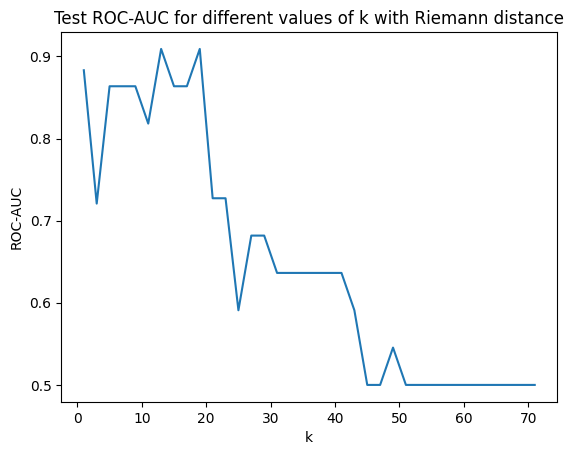

In [41]:
def plot_k_aurocs(min_k, max_k, auroc_scores, distance="Riemann"):
    x = np.linspace(min_k, max_k-1, len(auroc_scores))
    plt.plot(x, auroc_scores)
    plt.title("Test ROC-AUC for different values of k with " + distance + " distance")
    plt.ylabel("ROC-AUC")
    plt.xlabel("k")
    plt.show()

plot_k_aurocs(1, len(X_train), auroc_scores)

### Part 2: Step 4

Evaluate $k$ for KNN for with euclidean distance

Max AUROC:  0.7012987012987013 at k = :  17


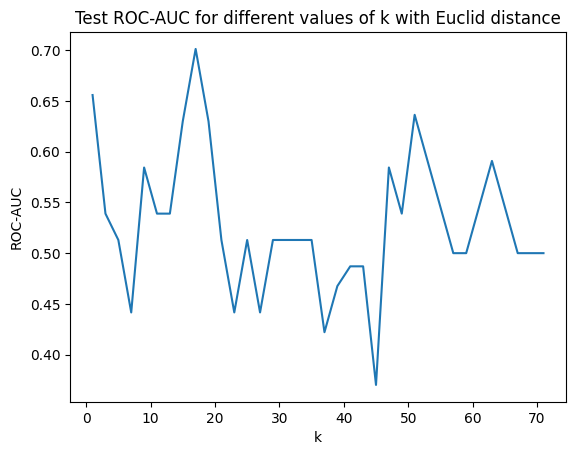

In [42]:
auroc_scores_euclid = get_k_auroc_scores(1, len(X_train)+1, "euclid")

print("Max AUROC: ", max(auroc_scores_euclid), "at k = : ", ((np.argmax(auroc_scores_euclid)+1)*2)-1)

plot_k_aurocs(1, len(X_train), auroc_scores_euclid, distance="Euclid")